In [1]:
from fastai.vision.all import *
    

In [2]:
from kornia import rgb_to_grayscale
class RGB2GreyTransform(DisplayedTransform):
    order = 15 # run after IntToFloatTransform
    def encodes(self, o:TensorImage):
         # expand restores tensor shape back to use c channels 
         # (ie. N,c,h,w) instead of N,1,h,w
         c = o.shape[1]
         return rgb_to_grayscale(o).expand(-1,c,-1,-1)
    
def label_from_path(path):
    [synset, first, second] = path.stem.split("_")
    return "same" if (first == second) else "different"

In [24]:
path = Path("/imagenet/combonet/train")
fnames = get_image_files(path)


dls = ImageDataLoaders.from_path_func(path, fnames, label_from_path, valid_pct=0.2, bs=64, batch_tfms=[Normalize.from_stats(*imagenet_stats),RGB2GreyTransform])

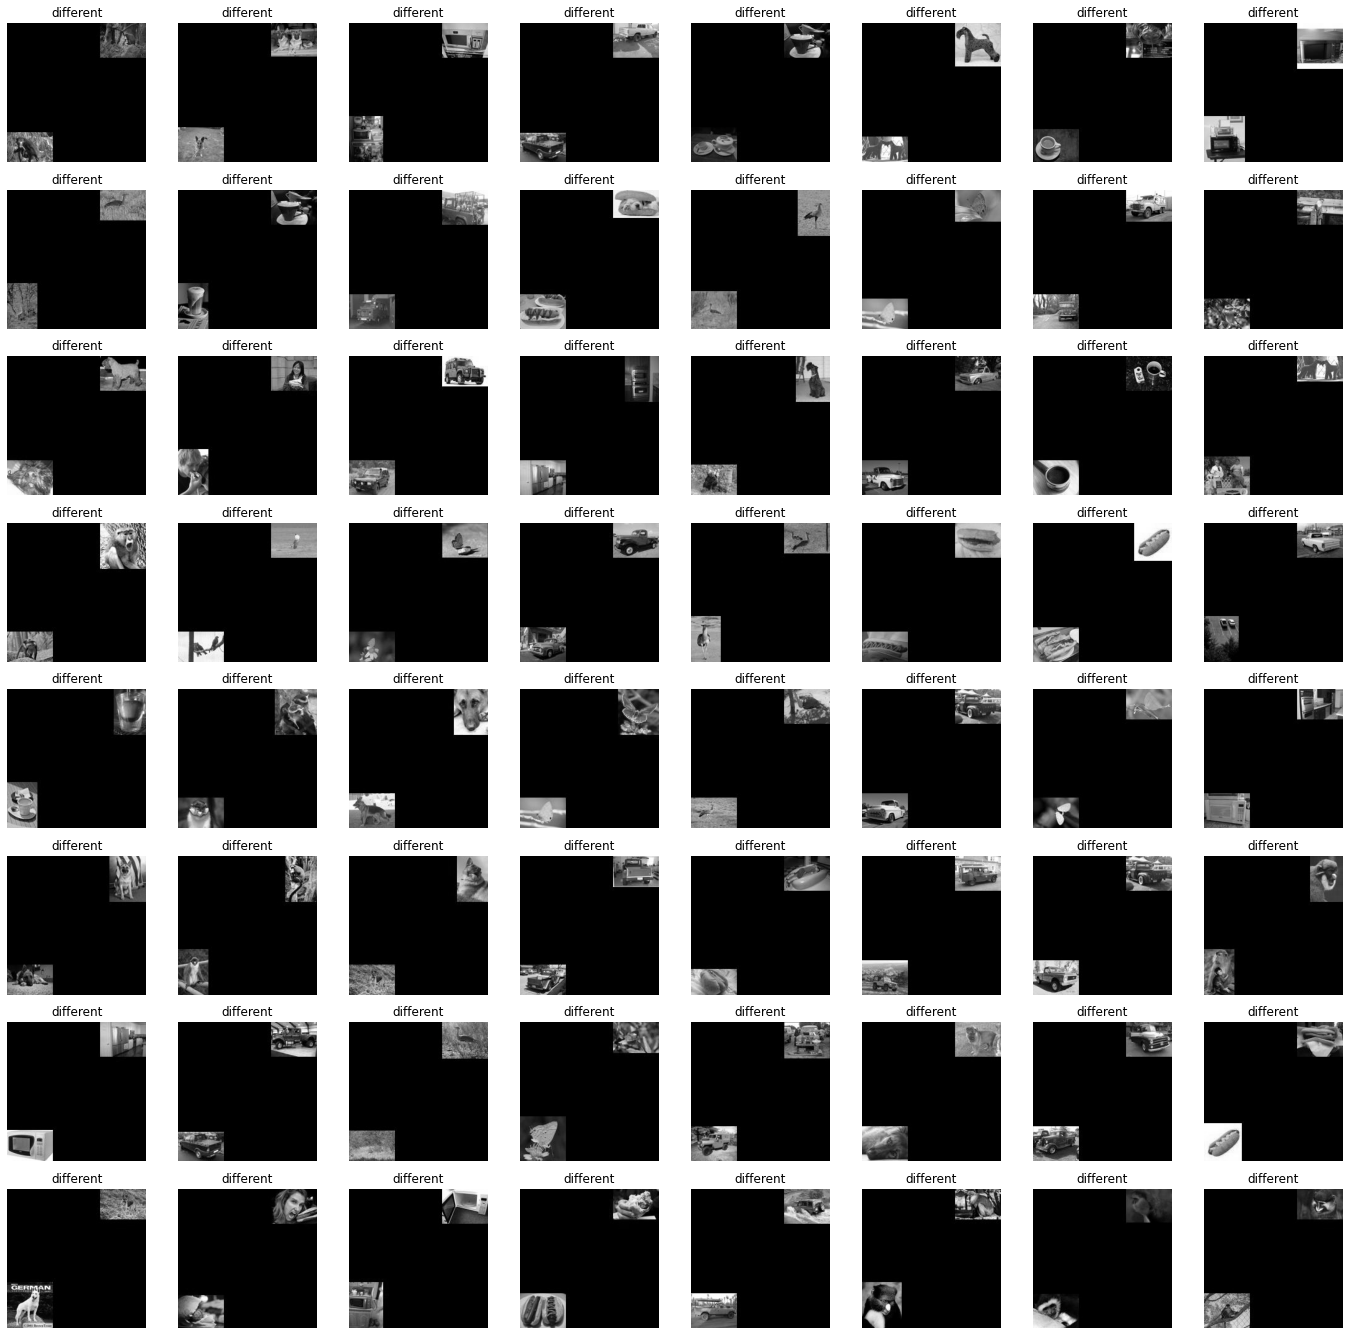

In [29]:
dls.show_batch(max_n=64)

In [20]:
def cornet_z_block(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=kernel_size // 2),
        nn.ReLU(inplace=True), # TODO: Find out what this does
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # Magic Numbers!
        Identity()
    )

cornet_z = nn.Sequential(
    cornet_z_block(3, 64, kernel_size=7, stride=2),
    cornet_z_block(64, 128),
    cornet_z_block(128, 256),
    cornet_z_block(256, 512),
    nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(512, 1000),
        Identity()
    )
)

loaded = Learner(dls, cornet_z, metrics=accuracy, splitter=default_split)
loaded.load('/imagenet/ILSVRC2012/models/cornet_z_imagenet_greyscale')

In [22]:
loaded.model[-1][2]= nn.Linear(in_features=512, out_features=2, bias=True)

In [26]:
loaded.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

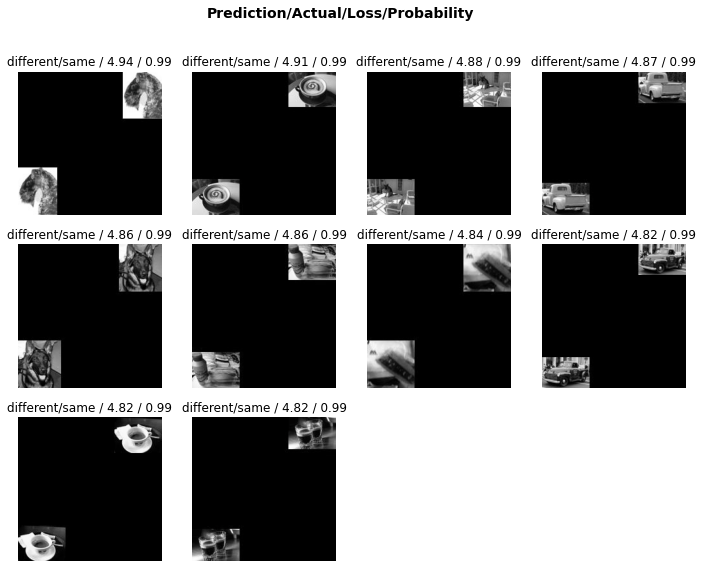

In [8]:
interp = Interpretation.from_learner(loaded)
interp.plot_top_losses(10)

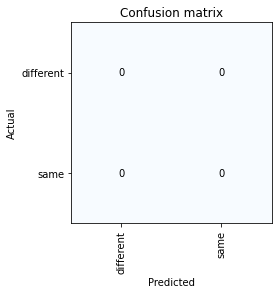

In [21]:
interp = ClassificationInterpretation.from_learner(loaded)
interp.plot_confusion_matrix()

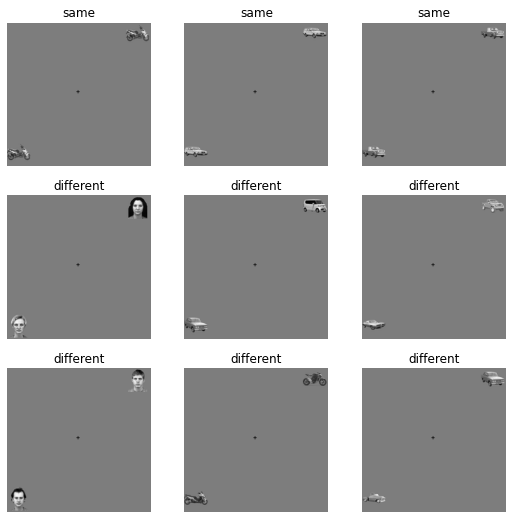

In [9]:
same_diff_dls = ImageDataLoaders.from_folder("../samediff", valid_pct=0.2)
same_diff_dls.show_batch()

In [10]:
same_diff_learner = Learner(same_diff_dls, loaded.model, splitter=default_split)
same_diff_learner.fit_one_cycle(100)

epoch,train_loss,valid_loss,time
0,0.513069,0.441066,00:02
1,0.521195,0.440031,00:02
2,0.526659,0.439799,00:02
3,0.525345,0.441612,00:02
4,0.521717,0.447003,00:02
5,0.519246,0.453172,00:02
6,0.518477,0.454207,00:02
7,0.515469,0.452023,00:02
8,0.513983,0.446995,00:02
9,0.513307,0.443105,00:02


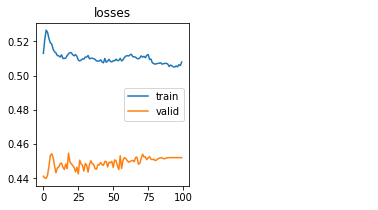

In [11]:
recorder = same_diff_learner.recorder
metrics =  np.stack(recorder.values)
names = recorder.metric_names[1:-1]
n = len(names) -1
fig, axs = subplots(1, 2)
axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')

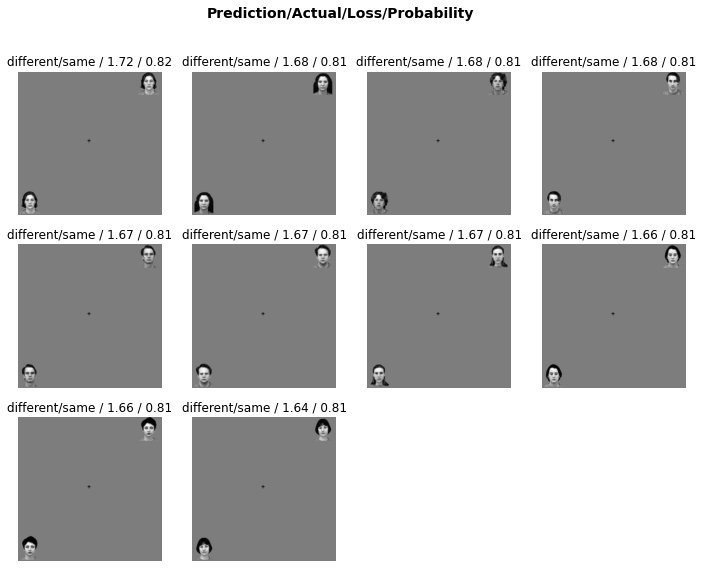

In [12]:
same_diff_interp = ClassificationInterpretation.from_learner(same_diff_learner)
same_diff_interp.plot_top_losses(10)

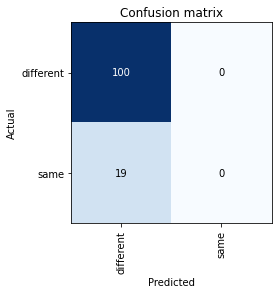

In [13]:
same_diff_interp.plot_confusion_matrix()

In [14]:
same_diff_learner.unfreeze()

In [15]:
same_diff_learner.fit_one_cycle(100)

epoch,train_loss,valid_loss,time
0,0.518194,0.452014,00:02
1,0.508680,0.452115,00:02
2,0.511549,0.452235,00:02
3,0.512329,0.452334,00:02
4,0.513418,0.452804,00:02
5,0.510020,0.454110,00:02
6,0.510307,0.453104,00:02
7,0.508093,0.452934,00:02
8,0.507782,0.451780,00:02
9,0.507650,0.452866,00:02


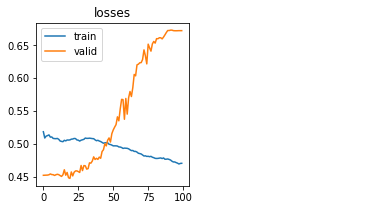

In [16]:
recorder = same_diff_learner.recorder
metrics =  np.stack(recorder.values)
names = recorder.metric_names[1:-1]
n = len(names) -1
fig, axs = subplots(1, 2)
axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')

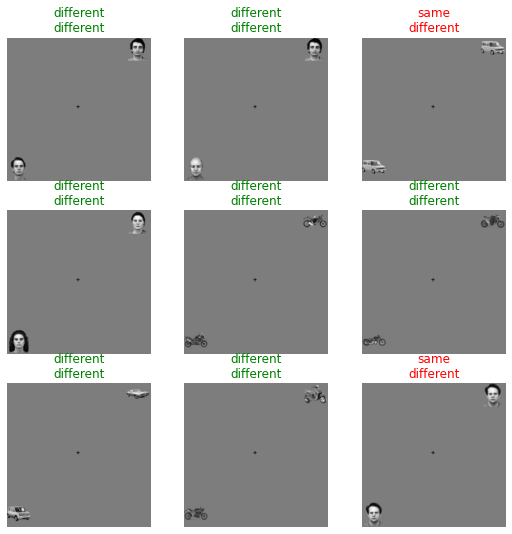

In [17]:
same_diff_learner.show_results()

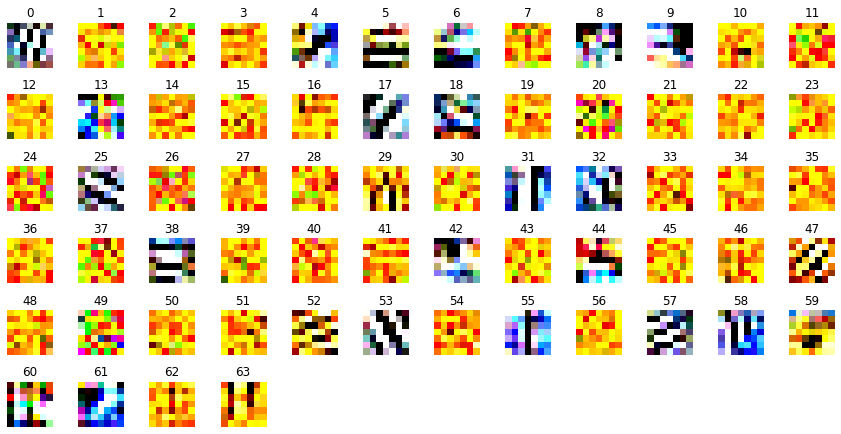

In [18]:
weights = same_diff_learner.model[0][0].weight.data.cpu()
def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    
plot_filters_multi_channel(weights)